**Набор данных CIFAR-10**<br>
Набор данных CIFAR-10 состоит из 60000 цветных изображений размером 32x32 в 10 классах, по 6000 изображений в классе. Имеется 50000 обучающих изображений и 10000 тестовых изображений.<br>

Набор данных разделен на пять обучающих пакетов и один тестовый пакет, в каждом по 10000 изображений. Тестовый пакет содержит ровно 1000 случайно выбранных изображений из каждого класса. Обучающие пакеты содержат остальные изображения в случайном порядке, но некоторые обучающие пакеты могут содержать больше изображений из одного класса, чем из другого. Между ними обучающие пакеты содержат ровно 5000 изображений из каждого класса.
<br>Датасет:<br>
https://www.cs.toronto.edu/~kriz/cifar.html

![image.png](attachment:fbb1aaa8-d029-4bde-881a-fe61984fca21.png)

In [56]:
# импортируем библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [57]:
# Загружаем Fashion-MNIST данные с использованием torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация данных
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [58]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

In [59]:
X_train.shape

torch.Size([60000, 28, 28])

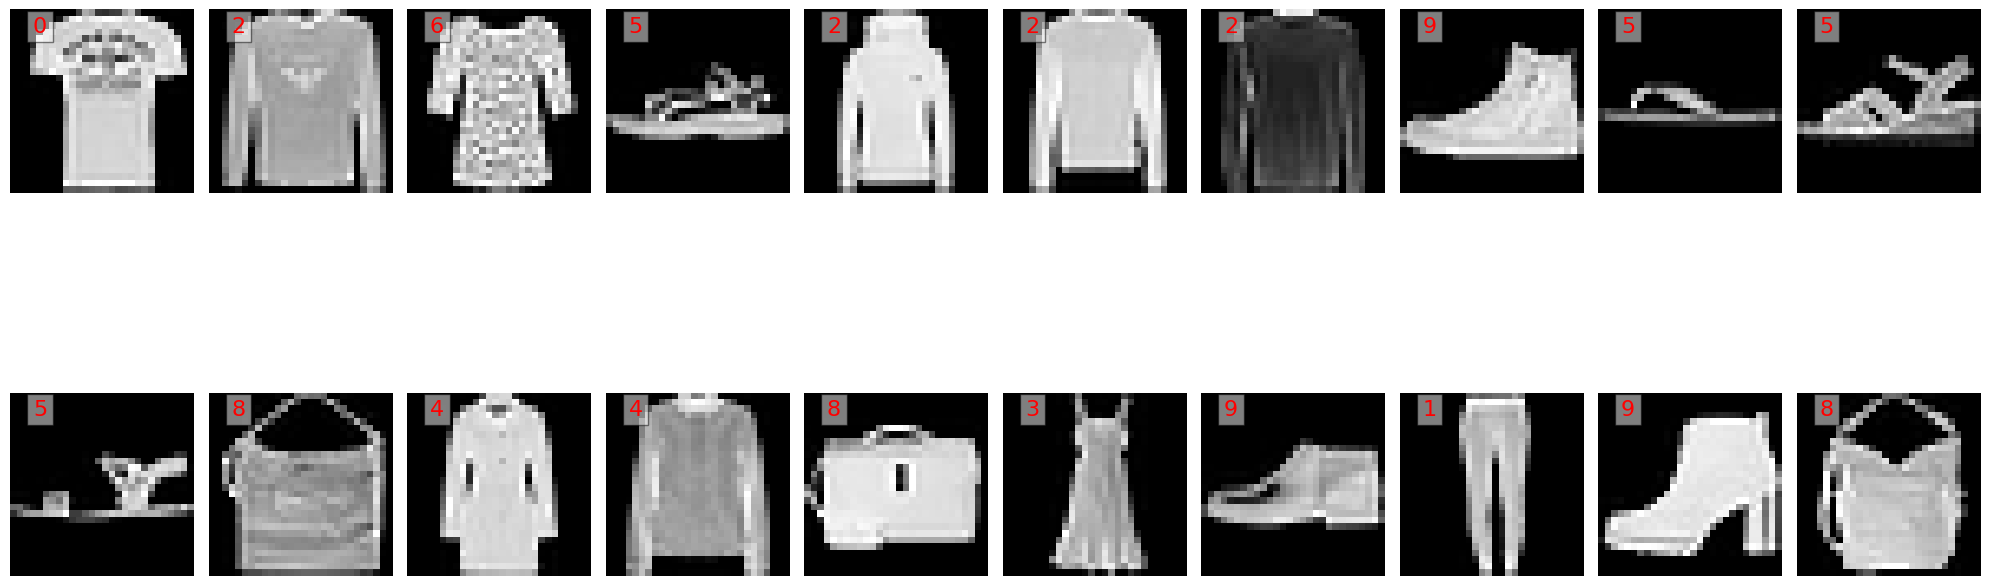

In [60]:

count = 0
sample_size = 20  # Количество картинок
rows, cols = 2, 10  # 2 ряда по 10 картинок

plt.figure(figsize=(20, 10))

for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count += 1
    plt.subplot(rows, cols, count)

    # Отображаем изображение в Ч/Б формате
    plt.imshow(X_train[i].squeeze(), cmap="gray")

    # Добавляем текст с меткой класса
    plt.text(x=3, y=3, s=int(y_train[i]), fontsize=16, color='red', bbox=dict(facecolor='white', alpha=0.5))

    plt.axis("off")  # Убираем оси

plt.tight_layout()
plt.show()


In [61]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(60000, 10000)

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,  18, 107,
         119, 103,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 155, 113,
          61, 118, 173, 117,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 110, 136,   0,   0,
           0,   0,   0, 167, 159,   0,   0,   2,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   1,   0,   6,   0,  72, 147,   0,   0,   5,
           0,   2,   0,   0, 174, 118,   0,   5,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   1,   5,   0,   0, 174,   4,   0,   4,   0,
           0,   0,   0,   0,   0, 204,  44,   0,   4,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   8,   0, 125, 128,   0,   9,   0,   0,
           0,   0,   0,   2,   0, 107, 152,   0,   6,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 

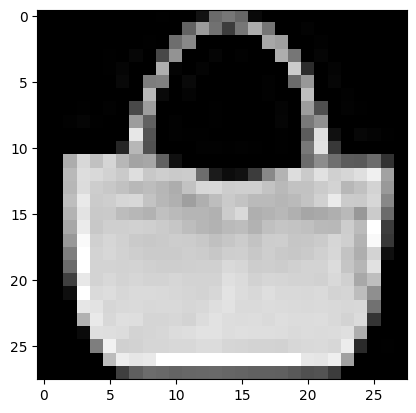

tensor(8)


In [62]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 100
# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")
# а так их видим мы

plt.imshow(X_train[im_number, :, :].squeeze(), cmap="gray")

plt.show()
print(y_train[im_number])

In [63]:
# ВЫВЕДЕМ КЛАССЫ ДАТАСЕТА И ИХ НАЗВАНИЯ
train_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [64]:
# посмотртим тип "картинок"
type(X_train[10, :, :]), type(y_train)

(torch.Tensor, torch.Tensor)

In [65]:
# ПОСМОТРИМ НА ОСИ ТЕНЗОРА, ЧТОБЫ ПОНИМАТЬ СМОЖЕТ ЛИ СЕТЬ ИХ ПРИНЯТЬ ИЛИ НУЖНО МЕНЯТЬ
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [66]:
# Проверим устройство для тренировки (GPU или CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



# Создаем DataLoader для тренировочных и тестовых данных
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Простая архитектура CNN для обучения
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14 * 14 * 32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.fc1(x)
        return x

# Создаем модель и отправляем на устройство
model = SimpleCNN().to(device)

In [67]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# История для анализа
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

# Обучение модели
for epoch in range(50):  # 50 эпох
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Прогоняем данные через модель
        preds = model(X_batch)

        # Считаем лосс
        loss_value = loss_fn(preds, y_batch)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

    # Оценка на тестовой выборке
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Получаем прогнозы
            test_preds = model(X_batch)
            test_loss += loss_fn(test_preds, y_batch).item()

            # Подсчитываем точность
            _, predicted = torch.max(test_preds, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Сохраняем данные для анализа
    avg_train_loss = running_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct / total

    train_loss_history.append(avg_train_loss)
    test_loss_history.append(avg_test_loss)
    test_accuracy_history.append(accuracy)

    # Выводим результаты
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Test Accuracy: {accuracy:.4f} - Test Loss: {avg_test_loss:.4f}")

Epoch 1 - Train Loss: 0.4159 - Test Accuracy: 0.8800 - Test Loss: 0.3364
Epoch 2 - Train Loss: 0.2974 - Test Accuracy: 0.8899 - Test Loss: 0.3123
Epoch 3 - Train Loss: 0.2647 - Test Accuracy: 0.8928 - Test Loss: 0.2943
Epoch 4 - Train Loss: 0.2412 - Test Accuracy: 0.8990 - Test Loss: 0.2844
Epoch 5 - Train Loss: 0.2258 - Test Accuracy: 0.9006 - Test Loss: 0.2854
Epoch 6 - Train Loss: 0.2122 - Test Accuracy: 0.9010 - Test Loss: 0.2829
Epoch 7 - Train Loss: 0.1984 - Test Accuracy: 0.9063 - Test Loss: 0.2727
Epoch 8 - Train Loss: 0.1873 - Test Accuracy: 0.9060 - Test Loss: 0.2731
Epoch 9 - Train Loss: 0.1768 - Test Accuracy: 0.9022 - Test Loss: 0.2852
Epoch 10 - Train Loss: 0.1709 - Test Accuracy: 0.9062 - Test Loss: 0.2775
Epoch 11 - Train Loss: 0.1607 - Test Accuracy: 0.9054 - Test Loss: 0.2738
Epoch 12 - Train Loss: 0.1573 - Test Accuracy: 0.9106 - Test Loss: 0.2697
Epoch 13 - Train Loss: 0.1483 - Test Accuracy: 0.9066 - Test Loss: 0.2763
Epoch 14 - Train Loss: 0.1404 - Test Accuracy: 

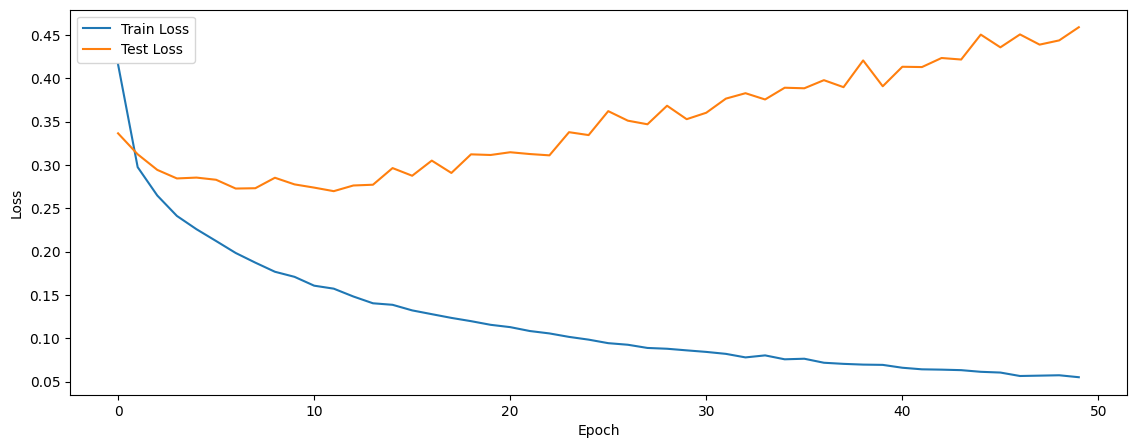

In [68]:
# Пример вывода графиков потерь и точности
plt.figure(figsize=(30, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

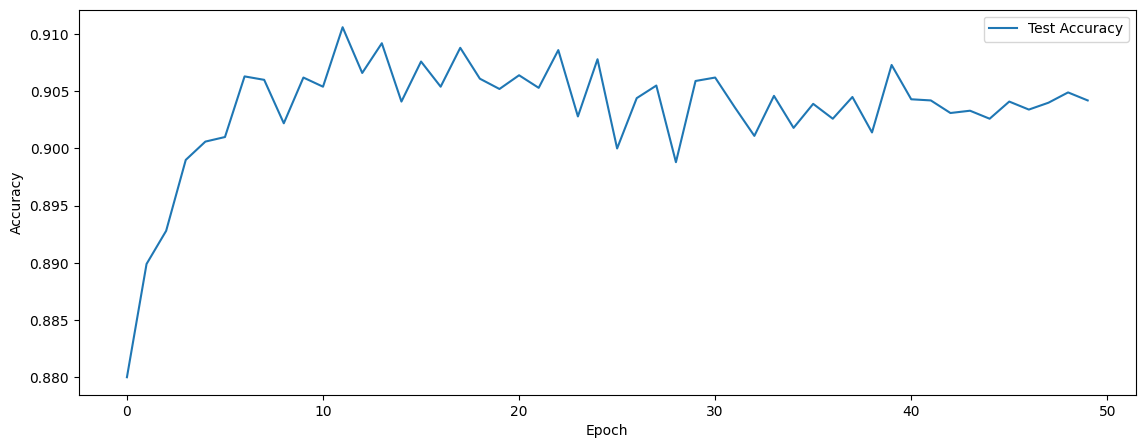

In [69]:
plt.figure(figsize=(30, 5))

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



# Сохранение и использование модели

In [169]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([28, 28])

In [170]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания
X_test.size()
# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 28, 28])

In [171]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(model, pickle_file)

In [172]:
import torch.nn as nn

# Считываем модель, сохраненную с помощью pickle
with open("model.pickle", "rb") as ifile:
    modelp = pickle.load(ifile)

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из pickle файла
print(modelp)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)


<ipython-input-172-420fb4658756>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [173]:
# смотрим тип модели
type(modelp)

__main__.SimpleCNN

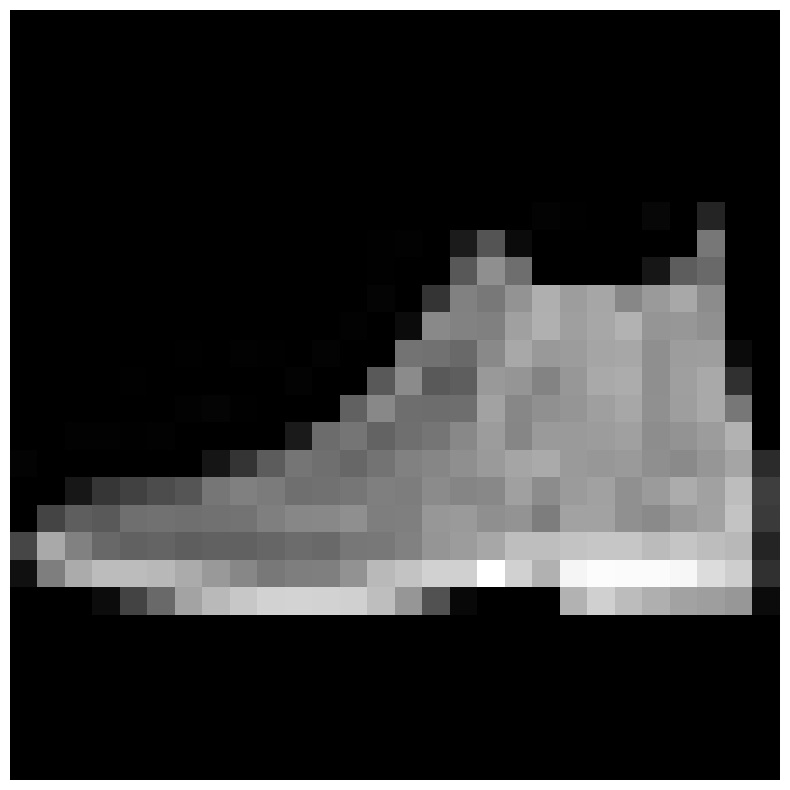

In [174]:
import matplotlib.pyplot as plt


# Берем первое изображение из тестового набора
image = X_test[0].cpu().detach()  # (1, 28, 28)

# Преобразуем тензор из (C, H, W) в (H, W, C) для корректного отображения
image = image.squeeze().numpy()  # Убираем лишний канал

# Увеличиваем размер изображения для отображения
plt.figure(figsize=(10, 10))

# Отображаем изображение в нормальных цветах
plt.imshow(image, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
plt.axis('off')  # Отключаем оси
plt.show()


In [175]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [176]:
# проверяем
t_data.shape

torch.Size([1, 28, 28])

In [177]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [178]:
# Преобразуем данные в float32 перед отправкой в модель
t_data = t_data.float()

# Теперь делаем предсказание
preds = modelp.forward(t_data)


In [179]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ -6105.6172, -12200.4648,  -7819.2422, -10118.0488,  -6549.2715,
          -3247.2571,  -3292.0139,  -2248.6445,  -1855.9467,   5040.4336]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [180]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [181]:
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [182]:
type(prediction)

numpy.ndarray

In [183]:
# Выводим предсказанные классы с их названиями
for pred in prediction:
    print(f"Prediction: {pred}, Label: {labels_dict.get(pred, 'Unknown class')}")

Prediction: 9, Label: Ankle boot


**ботильоны предсказаны верно.**
